In [1]:
import re
import seaborn as sns
import pickle
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from tqdm import tqdm

ERROR 1: PROJ: proj_create_from_database: Open of /project/cper_neon_aop/conda_envs/hls_nrt_env/share/proj failed


In [33]:
df_fq = pd.read_csv('../data/training/fecal_quality_2014_2023_pheno_metrics.csv')
df_graze = pd.read_csv('../data/ground/grazing/CARM_ActualGrazingInfov4_2013-2023.csv')
gdf_cper = gpd.read_file('../data/ground/boundaries/cper_pastures_2017_clip.shp')
with open('../models/diet_quality/rf_cp_ndvi_2014_2023.pkl', 'rb') as f:
    mod_cp = pd.compat.pickle_compat.load(f)
with open('../models/diet_quality/rf_dom_ndvi_2014_2023.pkl', 'rb') as f:
    mod_dom = pd.compat.pickle_compat.load(f)

/project/cper_neon_aop/conda_envs/hls_nrt_env/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/project/cper_neon_aop/conda_envs/hls_nrt_env/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/project/cper_neon_aop/conda_envs/hls_nrt_env/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Tryi

In [34]:
def abline(slope, intercept):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--')

# Prep data

In [35]:
gdf_cper = gdf_cper.dissolve('Past_Name_').reset_index()

In [36]:
df_fq = df_fq.drop(columns=['Concatenate', 'Herd', 'Pasture Name',
       'Rotation', r"Tag #'s", 'Notes',
       'Ecological Site', 'HerdTreat', 'Phase'])

In [37]:
df_fq = df_fq.groupby(['Year', 'PastureID', 'Treatment', 'Date', 'Week']).mean().reset_index()

In [38]:
df_fq = df_fq.rename(columns={'Crude Protein (%)': 'CP',
                              'DOM(%)': 'DOM',
                              'Treatment': 'Treatment_full'})

In [39]:
treatment_rename_dict = {
    'CARM1': 'CARM',
    'CARM2': 'CARM',
    'Paired TRM1': 'TRM',
    'Paired TRM2': 'TRM',
    'CARM77': 'CARM',
    'CARM107': 'CARM'
    
}
pasture_rename_dict = {
    'NH': '10S'
}

In [40]:
df_fq['Treatment'] = df_fq['Treatment_full'].apply(lambda x: treatment_rename_dict[x] if x in treatment_rename_dict.keys() else x)

In [41]:
df_graze['corr_fact'] = df_graze['comments'].apply(lambda x: 0.5 if 'fence open' in str(x) else 1.0)
df_graze['NumSteers_corr']= df_graze['NumSteers'] * df_graze['corr_fact']

In [42]:
df_graze

,ID,PastureCode,Treatment,Year,YearNum,Rest,SDperHa_June15LastYear_to_June15ThisYear,NumSteers,RotationOrder,TriggerUsed,TriggerUsedID,DateInPasture,DateOutPasture,Days,split_herd,comments,corr_fact,NumSteers_corr
0,1,NH,CARM,2012,2012,0.0,5.04,20.0,NaN,NaN,NaN,5/15/2012,9/26/2012,134.0,NaN,NaN,1.0,20.0
1,2,21N,CARM,2012,2012,0.0,4.93,20.0,NaN,NaN,NaN,5/15/2012,9/26/2012,134.0,NaN,NaN,1.0,20.0
2,3,26W,CARM,2012,2012,0.0,4.64,20.0,NaN,NaN,NaN,5/15/2012,9/26/2012,134.0,NaN,NaN,1.0,20.0
3,4,25NW,CARM,2012,2012,0.0,4.75,20.0,NaN,NaN,NaN,5/15/2012,9/26/2012,134.0,NaN,NaN,1.0,20.0
4,5,31W,CARM,2012,2012,0.0,4.78,23.0,NaN,NaN,NaN,5/15/2012,9/26/2012,134.0,NaN,NaN,1.0,23.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
266,342,17S,CARM,2023,2023,0.0,NaN,107.0,3.0,Max Days,NaN,9/21/2023,9/30/2023,9.0,107.0,herds split,1.0,107.0
267,343,7SE,CARM,2023,2023,0.0,NaN,77.0,4.0,Max Days,NaN,9/15/2023,9/30/2023,15.0,77.0,herds split,1.0,77.0
268,344,31W,CARM,2023,2023,0.0,NaN,107.0,4.0,Max Days,NaN,8/11/2023,9/21/2023,41.0,107.0,herds split,1.0,107.0
269,345,8E,CARM,2023,2023,1.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0


In [43]:
df_graze['PastureID'] = df_graze['PastureCode'].apply(lambda x: pasture_rename_dict[x] if x in pasture_rename_dict.keys() else x)

In [44]:
df_fq = pd.merge(df_fq, df_graze[['PastureID', 'Year', 'NumSteers_corr']],
                 how='left', on=['PastureID', 'Year'])

In [45]:
df_fq['period'] = np.ceil(df_fq['Week']/4).astype(int)
feature_names = ['NDVI', 'NDVI_d30', 'iNDVI', 't_peak_IRG', 'iNDVI_dry']

In [78]:
df_sub = df_fq[~df_fq['DOM'].isna()].copy()
df_sub = df_sub[~df_sub['CP'].isna()].copy()
#df_sub = df_sub[df_sub['Treatment'] == 'TRM'].copy()

In [79]:
df_sub.columns

Index(['Year', 'PastureID', 'Treatment_full', 'Date', 'Week', 'CP', 'DOM',
       'DOM/CP', 'Fecal Nitrogen (%)', 'Fecal Phosphorus (%)', 'Julian Day',
       'Precip(mm)', 'WOY', 'DOY', 'NDVI', 'NDVI_d30', 'iNDVI', 't_peak_IRG',
       'iNDVI_dry', 'Treatment', 'NumSteers_corr', 'period'],
      dtype='object')

In [80]:
df_sub['CP_pred'] = mod_cp.predict(df_sub[feature_names])
df_sub['DOM_pred'] = mod_dom.predict(df_sub[feature_names])

In [81]:
df_sub['Date'] = pd.to_datetime(df_sub['Date'])

In [97]:
df_sub = df_sub.groupby(['PastureID', 'Treatment', 'Year', 'Week']).mean().reset_index()

In [99]:
df_sub['CARM_Pair'] = df_sub['PastureID'].apply(lambda x: gdf_cper['CARM_Pair'][gdf_cper['Past_Name_'] == x].values.item())

In [100]:
drop_idxs = []
for group in tqdm(df_sub.groupby(['Year', 'Week'])):
    df_tmp = group[1]
    carm_pair = df_tmp[df_tmp['Treatment'] == 'CARM']['CARM_Pair']
    drop_idxs.extend(
        list(df_tmp[(df_tmp['Treatment'] == 'TRM') & (~df_tmp['PastureID'].isin(carm_pair))].index.values))

100%|██████████| 177/177 [00:00<00:00, 1260.90it/s]


In [104]:
keep_idxs = [x for x in df_sub.index.values if x not in drop_idxs]

In [105]:
for group in tqdm(df_sub.loc[keep_idxs].groupby(['Year', 'Week'])):
    if len(group[1][group[1]['Treatment'] == 'TRM']) < len(group[1][group[1]['Treatment'] == 'CARM']):
        print(group[0])

100%|██████████| 172/172 [00:00<00:00, 1964.02it/s]


In [72]:
df_sub.loc[drop_idxs]['Treatment'].unique()

array(['TRM'], dtype=object)

In [109]:
df_sub.loc[keep_idxs].value_counts('Treatment')

Treatment
CARM    230
TRM     230
dtype: int64

In [110]:
df_sub = df_sub.loc[keep_idxs]

In [111]:
df_sub_tmeans = df_sub.groupby(['Year', 'Week', 'Treatment'])[['CP', 'DOM', 'CP_pred', 'DOM_pred']].mean()

In [112]:
df_sub_tmeans_t = pd.pivot(df_sub_tmeans.reset_index(), columns='Treatment', index=['Year', 'Week'])

In [113]:
df_sub_tmeans_t['CP_diff'] = df_sub_tmeans_t['CP'].apply(lambda x: x['CARM'] - x['TRM'], axis=1)
df_sub_tmeans_t['DOM_diff'] = df_sub_tmeans_t['DOM'].apply(lambda x: x['CARM'] - x['TRM'], axis=1)
df_sub_tmeans_t['CP_pred_diff'] = df_sub_tmeans_t['CP_pred'].apply(lambda x: x['CARM'] - x['TRM'], axis=1)
df_sub_tmeans_t['DOM_pred_diff'] = df_sub_tmeans_t['DOM_pred'].apply(lambda x: x['CARM'] - x['TRM'], axis=1)

In [115]:
df_sub_tmeans_t = df_sub_tmeans_t.reset_index()

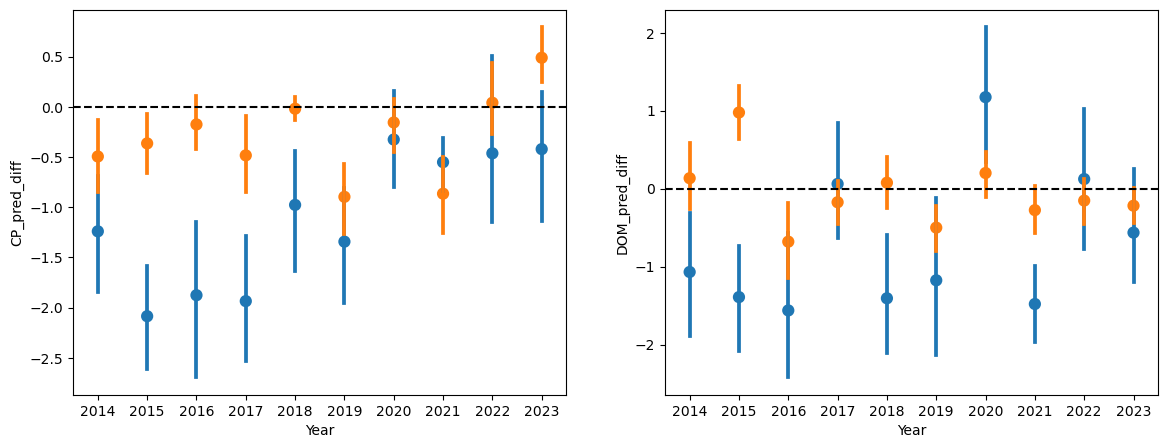

In [119]:
fig, axs = plt.subplots(ncols=2, figsize=(14, 5))
sns.pointplot(x='Year', y='CP_diff', data=df_sub_tmeans_t, join=False, ax=axs[0], color='tab:blue')
sns.pointplot(x='Year', y='CP_pred_diff', data=df_sub_tmeans_t, join=False, ax=axs[0], color='tab:orange')

sns.pointplot(x='Year', y='DOM_diff', data=df_sub_tmeans_t, join=False, ax=axs[1], color='tab:blue')
sns.pointplot(x='Year', y='DOM_pred_diff', data=df_sub_tmeans_t, join=False, ax=axs[1], color='tab:orange')

for ax in axs:
    ax.axhline(y=0, linestyle='dashed', color='k')

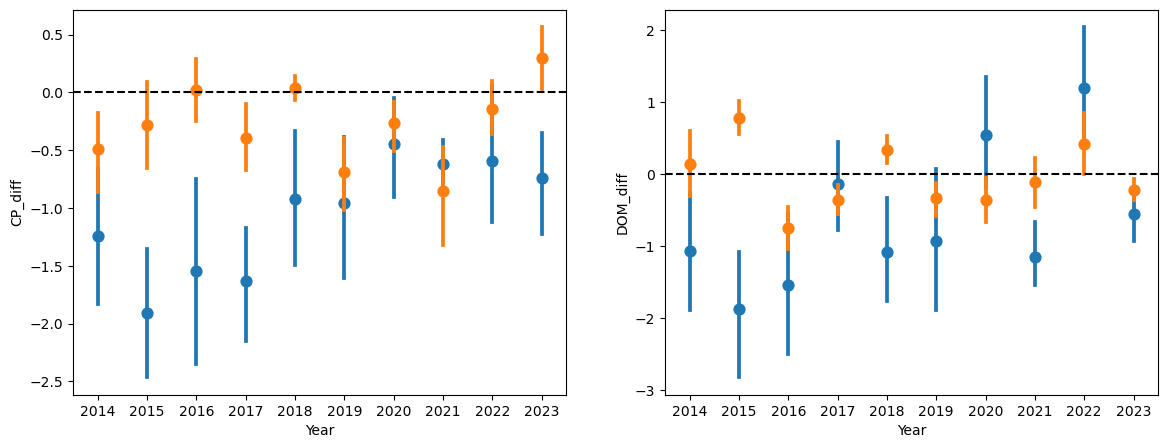

In [44]:
fig, axs = plt.subplots(ncols=2, figsize=(14, 5))
sns.pointplot(x='Year', y='CP_diff', data=df_sub_tmeans_t, linestyle='none', ax=axs[0])
sns.pointplot(x='Year', y='CP_pred_diff', data=df_sub_tmeans_t, linestyle='none', ax=axs[0])

sns.pointplot(x='Year', y='DOM_diff', data=df_sub_tmeans_t, linestyle='none', ax=axs[1])
sns.pointplot(x='Year', y='DOM_pred_diff', data=df_sub_tmeans_t, linestyle='none', ax=axs[1])

for ax in axs:
    ax.axhline(y=0, linestyle='dashed', color='k')

In [45]:
df_sub_tmeans_t['CP_diff_diff'] = df_sub_tmeans_t['CP_pred_diff'] - df_sub_tmeans_t['CP_diff']
df_sub_tmeans_t['DOM_diff_diff'] = df_sub_tmeans_t['DOM_pred_diff'] - df_sub_tmeans_t['DOM_diff']

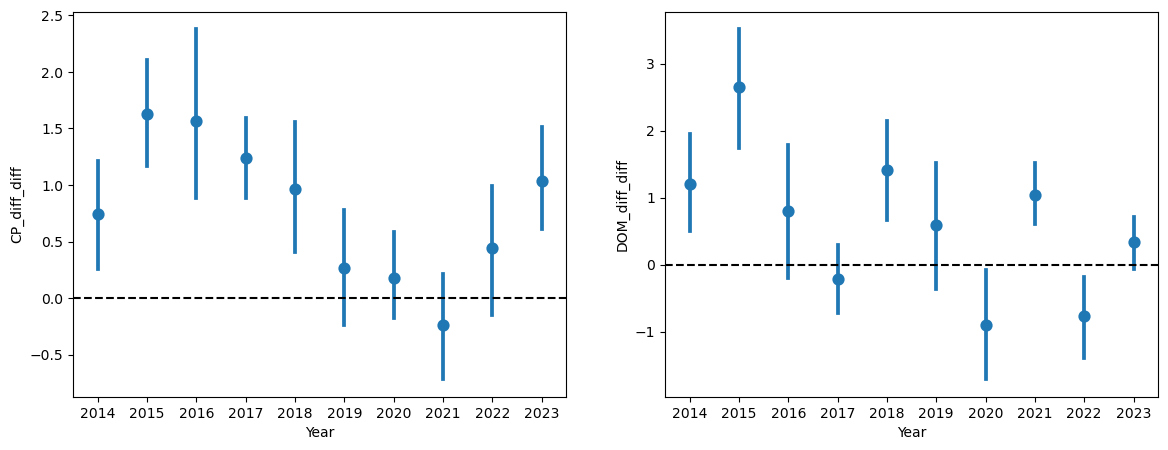

In [46]:
fig, axs = plt.subplots(ncols=2, figsize=(14, 5))
sns.pointplot(x='Year', y='CP_diff_diff', data=df_sub_tmeans_t, linestyle='none', ax=axs[0])
#sns.pointplot(x='Year', y='CP_pred_diff', data=df_sub_tmeans_t, linestyle='none', ax=axs[0])

sns.pointplot(x='Year', y='DOM_diff_diff', data=df_sub_tmeans_t, linestyle='none', ax=axs[1])
#sns.pointplot(x='Year', y='DOM_pred_diff', data=df_sub_tmeans_t, linestyle='none', ax=axs[1])

for ax in axs:
    ax.axhline(y=0, linestyle='dashed', color='k')

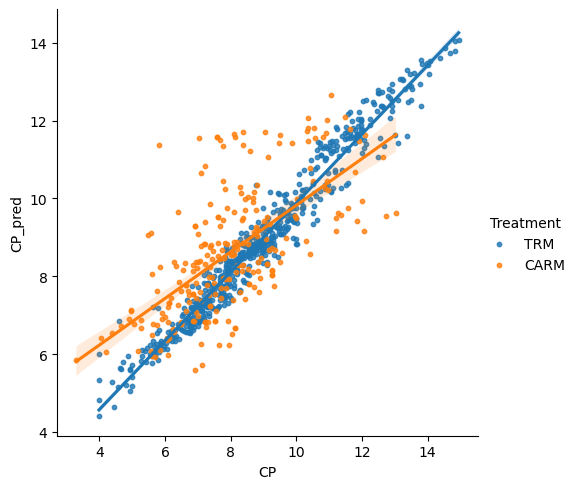

In [58]:
sns.lmplot(x='CP', y='CP_pred', hue='Treatment', data=df_sub, 
            scatter_kws={'s': 10})

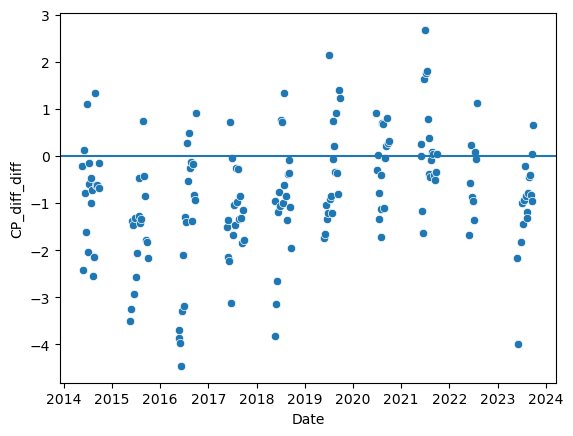

In [59]:
p= sns.scatterplot(x='Date', y='CP_diff_diff', data=df_sub_tmeans_t)
p.axhline(y=0)

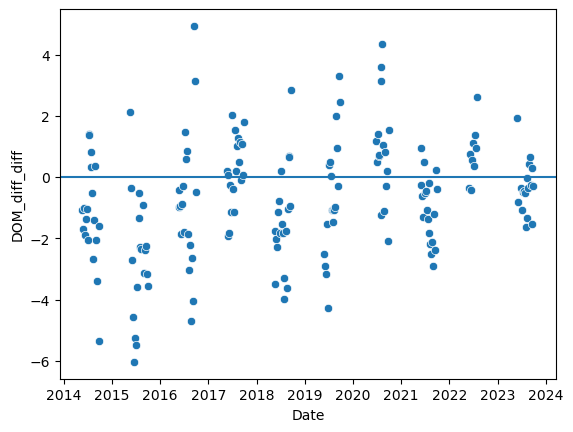

In [60]:
p= sns.scatterplot(x='Date', y='DOM_diff_diff', data=df_sub_tmeans_t)
p.axhline(y=0)